# Boardgame Recommender

## 1. Business Understanding

**BoardGameGeek** is a comprehensive online database that catalogues over 125,600 board games, providing access to reviews, discussion forums, and detailed information on individual titles. It is widely recognized as the most extensive repository of board game data available. In addition to serving as an information resource, the platform enables users to rate games on a 1–10 scale and to manage their personal game collections.

The aim of this project is to build a recommender system that uses data gathered from BoardGameGeek to generate board game recommendations based on user ratings. 
-item based collaborative filtering
Recomendations for selected user

In [170]:
# Target user
target_user = "TeemuVataja"

## 2. Data Understanding

Feature-rich multi-table dataset full of interesting information about Board Games:
[Board Games Database (BoardGameGeek, Kaggle)](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek)

This data set includes nine potential files for exploration and/or modeling. The files are as follows:

- GAMES - the basic information file with 47 features about each of 22k board games. Primary key is BGGId which is the BoardGameGeek game id.
- RATINGS_DISTRIBTION - includes full ratings distribution for each BGGId
- THEMES - table of themes for each BGGId
- MECHANICS - table of mechanics with binary flags per BGGId
- SUBCATEGORIES - table of subcategories with binary flags per BGGId
- ARTISTS_REDUCED - gives artist information for each BGGId. This file is reduced to artists with >3 works, with a binary flag indicating the game included an artist with <= 3 works
- DESIGNERS_REDUCED - gives designer information for each BGGId. This file is reduced to designers with >3 works, with a binary flag indicating the game included a designer with <= 3 works
- PUBLISHERS_REDUCED - gives publisher information for each BGGId. This file is reduced to publishers with >3 works, with a binary flag indicating the game included a publisher with <= 3 works
- USER_RATINGS - has all ratings for all BGGId with username. There are over 411k unique users and ~19 million ratings. Use in recommender system.

Source for the dataset:  
[BoardGameGeek](https://boardgamegeek.com/)


kerrotaan miten importataan data Data is imported from the kagglehub 

In [171]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("threnjen/board-games-database-from-boardgamegeek")

#TODO: tuo vaan ne mitä päädytään käyttämään, laita omiin blokkeihin ja selitykset ekaksi markdownina

# df_artists = pd.read_csv(os.path.join(path, "artists_reduced.csv"))
# display(df_artists.head())
# 
# df_designers = pd.read_csv(os.path.join(path, "designers_reduced.csv"))
# display(df_designers.head())



# df_mechanics = pd.read_csv(os.path.join(path, "mechanics.csv"))
# display(df_mechanics.head())
# 
# df_publishers = pd.read_csv(os.path.join(path, "publishers_reduced.csv"))
# display(df_publishers.head())

# df_ratings_distribution = pd.read_csv(os.path.join(path, "ratings_distribution.csv"))
# display(df_ratings_distribution.head())

# df_subcategories = pd.read_csv(os.path.join(path, "subcategories.csv"))
# display(df_subcategories.head())

# df_themes = pd.read_csv(os.path.join(path, "themes.csv"))
# display(df_themes.head())



# For the documentation file, just preview as text (not tabular)
# with open(os.path.join(path, "bgg_data_documentation.txt"), "r", encoding="utf-8") as f:
#     bgg_documentation = f.read()
# print(bgg_documentation[:500])  # first 500 characters

In [172]:
df_games = pd.read_csv(os.path.join(path, "games.csv"))
display(df_games.head())

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,21926,0,1,0,0,0,0,0,0


TODO df games plot? validate data

In [173]:
df_user_ratings = pd.read_csv(os.path.join(path, "user_ratings.csv"))
display(df_user_ratings.head())

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


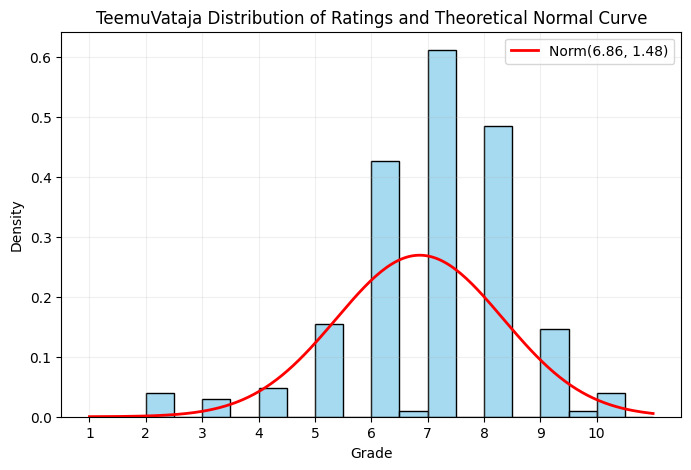

Information for: TeemuVataja
Mean: 6.86, Standard deviation: 1.48


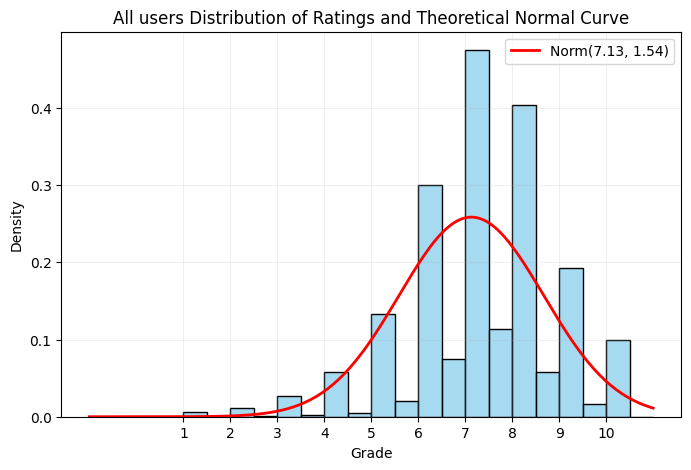

Information for: All users
Mean: 7.13, Standard deviation: 1.54


In [174]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_distribution_histrogram(title,user_data):
    
    bins = np.arange(1, 11 + 0.5, 0.5)

    #display(user_data.values.unique().count())
 
    # Laske keskiarvo ja keskihajonta
    mu = np.mean(user_data)
    sigma = np.std(user_data, ddof=1)
    
    
    # Piirrä histogrammi
    plt.figure(figsize=(8,5))
    sns.histplot(user_data, stat='density', bins=bins, kde=False, color='skyblue', edgecolor='black')
    
    # Laske ja piirrä teoreettinen normaalijakauma
    x = np.linspace(min(user_data)-1, max(user_data)+1, 200)
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    plt.plot(x, pdf, color='red', linewidth=2, label=f'Norm({mu:.2f}, {sigma:.2f})')
    
    # Aseta otsikot ja legendat
    plt.title(f'{title} Distribution of Ratings and Theoretical Normal Curve')
    plt.xticks(range(1, 11))    

    plt.xlabel('Grade')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show() 
    print(f"Information for: {title}")
    print(f"Mean: {mu:.2f}, Standard deviation: {sigma:.2f}")

    
    
user_data = df_user_ratings[df_user_ratings["Username"] == target_user]["Rating"]
create_distribution_histrogram(target_user,user_data)
all_users_data =df_user_ratings["Rating"]
create_distribution_histrogram("All users",all_users_data)


validate data


GAMES
	BGGId			BoardGameGeek game ID
	Name			Name of game
	Description		Description, stripped of punctuation and lemmatized
	YearPublished		First year game published
	GameWeight		Game difficulty/complexity
	AvgRating		Average user rating for game
	BayesAvgRating		Bayes weighted average for game (x # of average reviews applied)
	StdDev			Standard deviation of Bayes Avg
	MinPlayers		Minimum number of players
	MaxPlayers		Maximun number of players
	ComAgeRec		Community's recommended age minimum
	LanguageEase		Language requirement
	BestPlayers		Community voted best player count
	GoodPlayers		List of community voted good plater counts
	NumOwned		Number of users who own this game
	NumWant			Number of users who want this game
	NumWish			Number of users who wishlisted this game
	NumWeightVotes		? Unknown
	MfgPlayTime		Manufacturer Stated Play Time
	ComMinPlaytime		Community minimum play time
	ComMaxPlaytime		Community maximum play time
	MfgAgeRec		Manufacturer Age Recommendation
	NumUserRatings		Number of user ratings
	NumComments		Number of user comments
	NumAlternates		Number of alternate versions
	NumExpansions		Number of expansions
	NumImplementations	Number of implementations
	IsReimplementation	Binary - Is this listing a reimplementation? 
	Family			Game family
	Kickstarted		Binary - Is this a kickstarter?
	ImagePath		Image http:// path
	Rank:boardgame		Rank for boardgames overall
	Rank:strategygames	Rank in strategy games
	Rank:abstracts		Rank in abstracts
	Rank:familygames	Rank in family games
	Rank:thematic		Rank in thematic
	Rank:cgs		Rank in card games
	Rank:wargames		Rank in war games
	Rank:partygames		Rank in party games
	Rank:childrensgames	Rank in children's games
	Cat:Thematic		Binary is in Thematic category
	Cat:Strategy		Binary is in Strategy category
	Cat:War			Binary is in War category
	Cat:Family		Binary is in Family category
	Cat:CGS			Binary is in Card Games category
	Cat:Abstract		Binary is in Abstract category
	Cat:Party		Binary is in Party category
	Cat:Childrens		Binary is in Childrens category


MECHANICS
	BGGId			BoardGameGeek game ID	
	Remaining headers are various mechanics with binary flag


THEMES
	BGGId			BoardGameGeek game ID
	Remaining headers are various themes with binary flag


SUBCATEGORIES
	BGGId			BoardGameGeek game ID
	Remaining headers are various subcategories with binary flag


ARTISTS_REDUCED
	BGGId			BoardGameGeek game ID
	Low-Exp Artist		Indicates game has an unlisted artist with <= 3 entries
	Remaining headers are various artists with binary flag


DESIGNERS_REDUCED
	BGGId			BoardGameGeek game ID
	Low-Exp Designer	Indicates game has an unlisted designer with <= 3 entries
	Remaining headers are various subcategories with binary flag


PUBLISHERS_REDUCED
	BGGId			BoardGameGeek game ID
	Low-Exp Publisher	Indicated games has an unlisted publisher with <= 3 entries
	Remaining headers are various subcategories with binary flag


USER_RATINGS
	BGGId			BoardGameGeek game ID	
	Rating			Raw rating given by user
	Username		User giving rating


RATINGS_DISTRIBUTION
	BGGId			BoardGameGeek game ID
	Numbers 0.0-10.0	Number of ratings per rating header
	total_ratings		Total number of ratings for game

## 3. Data Preparation

## User table is consisted with combined data from ratings. Rating count is added to give information how many ratings user has made.

In [175]:
from surprise import Reader, Dataset

# Example df_user_ratings has columns: Username, Item, Rating

# Build user table with unique IDs and rating counts
# If we ever need a dataframe without ratings just copy df_users before this step
df_users = (
    df_user_ratings.groupby("Username")
    .size()  # counts ratings per user
    .reset_index(name="RatingCount")
    .reset_index(names="UserId")  # create UserId from row index
)

#TODO: printtejä

print("Total number of users:")
display(len(df_users))

print("User table")
display(df_users.head())

print("User rating table")
display(df_user_ratings.head())

print("Selected user table")
display(df_users[df_users["Username"] == target_user])

Total number of users:


411374

User table


,UserId,Username,RatingCount
0,0,Fu_Koios,2
1,1,beastvol,9
2,2,mycroft,14
3,3,woh,5
4,4,(mostly) harmless,1


User rating table


,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


Selected user table


,UserId,Username,RatingCount
187874,187874,TeemuVataja,206


## Users with less than  10 ratings are filtered out from the data

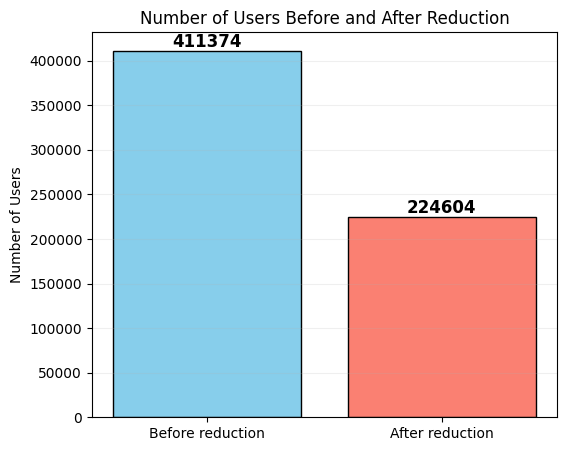

In [176]:
#print(f"Length of users set before reduction: {len(df_users)}")

df_users_reduced = df_users[df_users['RatingCount'] >= 10]

#print(f"Length of users set after reduction: {len(df_users_reduced)}")

# Examples
before = len(df_users)
after = len(df_users_reduced)

# Data and labels
counts = [before, after]
labels = ['Before reduction', 'After reduction']

# Draw diagram
plt.figure(figsize=(6,5))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black')

# Add numbers to on top of bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Users')
plt.title('Number of Users Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()

## Games less than 100 reviews are filtered out from the data

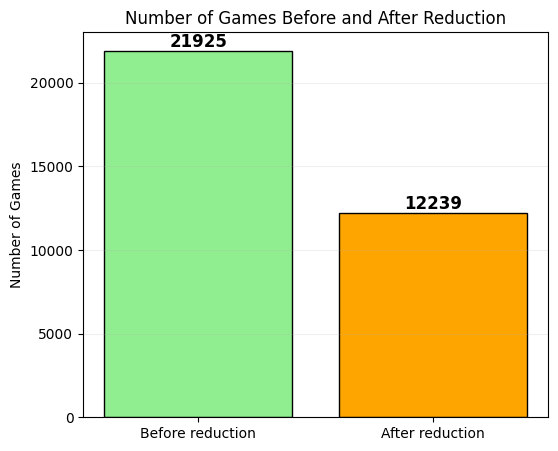

In [177]:
#print(f"Length of games set before reduction: {len(df_games)}")

df_games_reduced = df_games[df_games['NumUserRatings'] >= 100]

#print(f"Length of games set after reduction: {len(df_games_reduced)}")
import matplotlib.pyplot as plt

# Examples
before = len(df_games)
after = len(df_games_reduced)

# Data and labels
counts = [before, after]
labels = ['Before reduction', 'After reduction']

# Draw diagram
plt.figure(figsize=(6,5))
bars = plt.bar(labels, counts, color=['lightgreen', 'orange'], edgecolor='black')

# Add numbers to on top of bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Games')
plt.title('Number of Games Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()

## Here you can see how little reducing  users and games affected to ratings count. Data will be half of its size but relevant information in not greatly affected

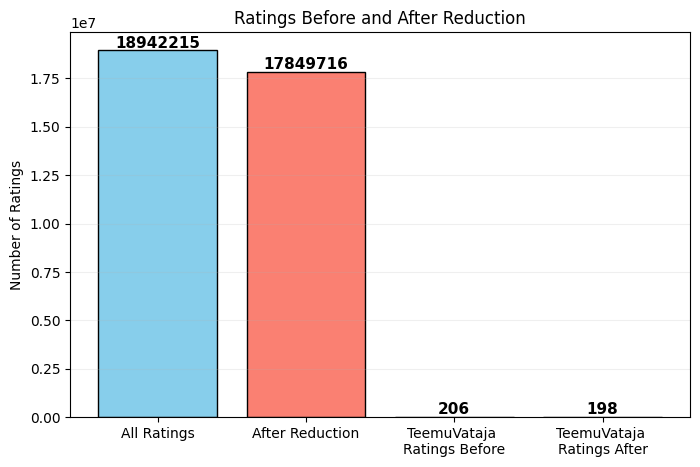

In [183]:
#print(f"Length of ratings set before reduction: {len(df_user_ratings)}")

df_ratings_reduced = df_user_ratings[df_user_ratings["BGGId"].isin(df_games_reduced["BGGId"])]
df_ratings_reduced = df_ratings_reduced[df_ratings_reduced["Username"].isin(df_users_reduced["Username"])]

#print(f"Length of ratings set after reduction: {len(df_ratings_reduced)}")
#print(f"Valid ratings after pruning for target user: {len(df_ratings_reduced[df_ratings_reduced['Username'] == target_user])}")

before = len(df_user_ratings)
after = len(df_ratings_reduced)
target_user_count_before = len(df_user_ratings[df_user_ratings['Username'] == target_user])
target_user_count_after = len(df_ratings_reduced[df_ratings_reduced['Username'] == target_user])

# Data and labels
counts = [before, after, target_user_count_before, target_user_count_after]
labels = ['All Ratings', 'After Reduction', f'{target_user} \nRatings Before',  f'{target_user} \nRatings After']

# Draw diagram
plt.figure(figsize=(8,5))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen', 'orange'], edgecolor='black')

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Number of Ratings')
plt.title('Ratings Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()


## 4. Modeling


Selitä mitä nyt tehdään
# SVD = item x item
# KNN = user x user
Mallin luonti ja tallennus tietokoneelle. Jos ei luotu niin kouluttaa sen ja tallentaa

In [ ]:
from surprise import SVD, dump
from surprise.model_selection import train_test_split
import os

def create_surprise_dataset(df, user_id, item_id, ratings, reader):
    return Dataset.load_from_df(df[[user_id, item_id, ratings]], reader)

data = create_surprise_dataset(df_ratings_reduced, "Username", "BGGId", "Rating", Reader(rating_scale=(0.0, 10.0)))

# def load_test_model(model_name, algo, force_recreate=False):
#     if not os.path.exists(model_name) or force_recreate:
#         surprise_dataset = create_surprise_dataset(df_ratings_reduced, "Username", "BGGId", "Rating", Reader(rating_scale=(0.0, 10.0))) # First create surprise dataset from an existing Pandas Dataframe. Hardcoded for now
#         trainset, testset = train_test_split(surprise_dataset, test_size=0.2)
#         algo.fit(trainset)
#         #surprise_trainset = surprise_dataset.build_full_trainset() # Then build the trainset
#         #algo.fit(surprise_trainset) # Lastly create the model using said training set
#         
#         dump.dump(model_name, algo=algo)
#         return algo, testset
# 
#     _, algo = dump.load(model_name)
#     return algo
# 
# model, testset = load_test_model("testmodel.pkl", SVD(n_factors=50, random_state=666))

predictions funktiot.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def top_similar_users(username, model, top_n=10):
    """
    Returns top-N similar users to a given username (raw ID).
    """
    try:
        inner_uid = model.trainset.to_inner_uid(username)
    except ValueError:
        return []

    user_vec = model.pu[inner_uid].reshape(1, -1)
    sims = cosine_similarity(user_vec, model.pu)[0]

    # Exclude self
    top_inner = np.argsort(-sims)[1:top_n+1]
    return [model.trainset.to_raw_uid(i) for i in top_inner]


Selitystä

In [ ]:

def user_predictions(username, model, top_n_items=None):
    """
    Predict ratings for all unseen items for a given username.
    Optionally, return only top-N items.
    """
    try:
        inner_uid = model.trainset.to_inner_uid(username)
    except ValueError:
        return []

    # Items already rated by user
    user_items = {iid for (iid, _) in model.trainset.ur[inner_uid]}
    all_items = set(range(model.trainset.n_items))
    unseen_items = all_items - user_items

    # Build test set (user x unseen items)
    testset = [(username, model.trainset.to_raw_iid(i), 0.) for i in unseen_items]

    # Get predictions
    predictions = model.test(testset)

    # Optionally keep top-N items
    if top_n_items:
        predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n_items]

    return predictions


Selitystä

In [ ]:
def user_predictions_from_similar(username, model, top_n_users=1000, top_n_items=10):
    """
    Predict items for a user based on items liked by similar users.
    """
    similar_users = top_similar_users(username, model, top_n=top_n_users)

    # Collect items rated by similar users
    similar_items = set()
    for su in similar_users:
        inner_uid = model.trainset.to_inner_uid(su)
        similar_items.update([model.trainset.to_raw_iid(iid) for (iid, _) in model.trainset.ur[inner_uid]])

    # Filter out items already rated by target user
    inner_uid_target = model.trainset.to_inner_uid(username)
    user_items = {model.trainset.to_raw_iid(iid) for (iid, _) in model.trainset.ur[inner_uid_target]}
    candidate_items = similar_items - user_items

    # Build test set and predict
    testset = [(username, iid, 0.) for iid in candidate_items]
    predictions = model.test(testset)
    predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n_items]

    return predictions


Selitystä

## 5. Evaluation

In [ ]:
from surprise.model_selection import cross_validate

cross_validate(SVD(n_factors=50, random_state=666), data, measures=["RMSE", "MAE"], cv=3, return_train_measures=True, verbose=True)

## 6. Deployment

In [ ]:
def load_surprise_model(model_name, algo, force_recreate=False):
    if not os.path.exists(model_name) or force_recreate:
        surprise_dataset = create_surprise_dataset(df_ratings_reduced, "Username", "BGGId", "Rating", Reader(rating_scale=(0.0, 10.0))) # First create surprise dataset from an existing Pandas Dataframe. Hardcoded for now
        surprise_trainset = surprise_dataset.build_full_trainset() # Then build the trainset
        algo.fit(surprise_trainset) # Lastly create the model using said training set
        
        dump.dump(model_name, algo=algo)
        return algo

    _, algo = dump.load(model_name)
    return algo

model = load_surprise_model("model.pkl", SVD(n_factors=50,random_state=666))

##tehdään tällä juttutja

tähän juttuja mallin luonnista

In [ ]:
#TODO: poista sarakkeita tulostuksesta
# Example usage
predictions = user_predictions_from_similar(target_user, model)

top10 = sorted(predictions, key=lambda x: x.est, reverse=True)
for pred in top10:
    print(pred.iid, pred.est)
    display(df_games_reduced[df_games_reduced["BGGId"] == pred.iid])
    

ajatuksia